# Bank of England Base Rate Prediction

### Objective
Model and predict upcoming Bank of England Base Rate decisions using data from the latest
Monetary Policy Report (February 2025). The model leverages polynomial regression to fit
quarterly rate data and generate daily predictions, focusing on Monetary Policy Committee
(MPC) meeting dates.

### Workflow
1. **Process Monetary Policy Report Data**: Extract and prepare quarterly rate data.
2. **Fit Polynomial Models**: Test polynomial regression models and select the best fit.
3. **Generate Daily Rate Predictions**: Interpolate daily rates using the best model.
4. **Extract Predicted Rates**: Output predictions for specific MPC meeting dates.


## Setup and Imports

This section imports required libraries and ensures dependencies are installed. The
libraries include tools for data manipulation, numerical operations, visualization, and
model evaluation.

In [1]:
# Uncomment to install required libraries if not already installed
# !pip install pandas numpy matplotlib scikit-learn

# Standard library imports
from typing import List, Tuple

# Third-party imports
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.metrics import r2_score
from numpy.polynomial.polynomial import Polynomial

## 1. Process Monetary Policy Report Data

This section processes quarterly rate data from the Bank of England's Monetary Policy
Report (February 2025). The data includes 15-day average forward rates derived from
Overnight Index Swap (OIS) rates, assumed to represent the first day of each quarter.
Additional Bank Rate decisions from February 6 and March 20, 2025, are included.

The data is converted into a numerical format (days since the start date) for polynomial
fitting.

In [2]:
# Constants for quarterly data
QUARTERLY_DATES: List[str] = [
    "2025-01-01", "2025-02-06", "2025-03-20", "2025-04-01", "2025-07-01",
    "2025-10-01", "2026-01-01", "2026-04-01", "2026-07-01", "2026-10-01",
    "2027-01-01", "2027-04-01", "2027-07-01", "2027-10-01", "2028-01-01",
    "2028-04-01"
]

QUARTERLY_RATES: List[float] = [
    4.55, 4.50, 4.50, 4.37, 4.23, 4.16, 4.15, 4.15, 4.13, 4.11,
    4.08, 4.06, 4.03, 4.01, 3.99, 3.98
]

def process_quarterly_data(dates: List[str], rates: List[float]) -> pd.DataFrame:
    """Process quarterly rate data into a DataFrame with numerical days.

    Args:
        dates: List of date strings in YYYY-MM-DD format.
        rates: List of corresponding interest rates.

    Returns:
        DataFrame with columns: Date (datetime), Rate (float), Days (float).
    """
    # Create DataFrame
    df = pd.DataFrame({"Date": dates, "Rate": rates})

    # Convert dates to datetime
    df["Date"] = pd.to_datetime(df["Date"])

    # Calculate days since start date
    start_date = df["Date"].min()
    df["Days"] = (df["Date"] - start_date).dt.total_seconds() / (24 * 3600)

    return df

# Process quarterly data
quarterly_df = process_quarterly_data(QUARTERLY_DATES, QUARTERLY_RATES)

# Define date range constants
START_DATE: pd.Timestamp = quarterly_df["Date"].min()
END_DATE: pd.Timestamp = quarterly_df["Date"].max()

## 2. Fit Polynomial Models

This section tests polynomial regression models of varying degrees (1 to 5) to fit the
quarterly rate data. The best model is selected based on the adjusted R-squared score to
balance fit and complexity, avoiding overfitting.

The adjusted R-squared accounts for the number of predictors, penalizing overly complex
models.

In [3]:
def adjusted_r2(r2: float, n: int, p: int) -> float:
    """Calculate adjusted R-squared score.

    Args:
        r2: R-squared score.
        n: Number of observations.
        p: Number of predictors (degree of polynomial).

    Returns:
        Adjusted R-squared score.
    """
    return 1 - (1 - r2) * (n - 1) / (n - p - 1)

def fit_polynomial_models(
    x: np.ndarray, y: np.ndarray, max_degree: int = 5
) -> Tuple[Polynomial, int, float]:
    """Fit polynomial models and select the best based on adjusted R-squared.

    Args:
        x: Array of input days.
        y: Array of corresponding rates.
        max_degree: Maximum polynomial degree to test.

    Returns:
        Tuple of (best polynomial, best degree, best adjusted R-squared).
    """
    best_poly = None
    best_degree = 0
    best_adj_r2 = -np.inf

    n = len(x)
    for degree in range(1, max_degree + 1):
        # Fit polynomial
        poly = Polynomial.fit(x, y, degree)
        y_pred = poly(x)

        # Calculate R-squared and adjusted R-squared
        r2 = r2_score(y, y_pred)
        adj_r2 = adjusted_r2(r2, n, degree)

        print(
            f"Degree {degree} -> R-squared: {r2:.6f}, "
            f"Adjusted R-squared: {adj_r2:.6f}"
        )

        # Update best model if adjusted R-squared is higher
        if adj_r2 > best_adj_r2:
            best_adj_r2 = adj_r2
            best_poly = poly
            best_degree = degree

    print(f"\nBest fit -> Degree {best_degree}")
    return best_poly, best_degree, best_adj_r2

# Fit polynomial models to quarterly data
best_poly, best_degree, best_adj_r2 = fit_polynomial_models(
    quarterly_df["Days"], quarterly_df["Rate"]
)

Degree 1 -> R-squared: 0.812083, Adjusted R-squared: 0.798661
Degree 2 -> R-squared: 0.917485, Adjusted R-squared: 0.904790
Degree 3 -> R-squared: 0.963016, Adjusted R-squared: 0.953770
Degree 4 -> R-squared: 0.977252, Adjusted R-squared: 0.968980
Degree 5 -> R-squared: 0.977509, Adjusted R-squared: 0.966263

Best fit -> Degree 4


## 3. Generate Daily Rate Predictions

Using the best polynomial model, this section generates daily rate predictions over the
date range. Predicted rates are rounded to the nearest 0.25% to reflect practical Bank
Rate increments. The results are visualized with a plot showing the polynomial fit,
adjusted predictions, and original quarterly data.

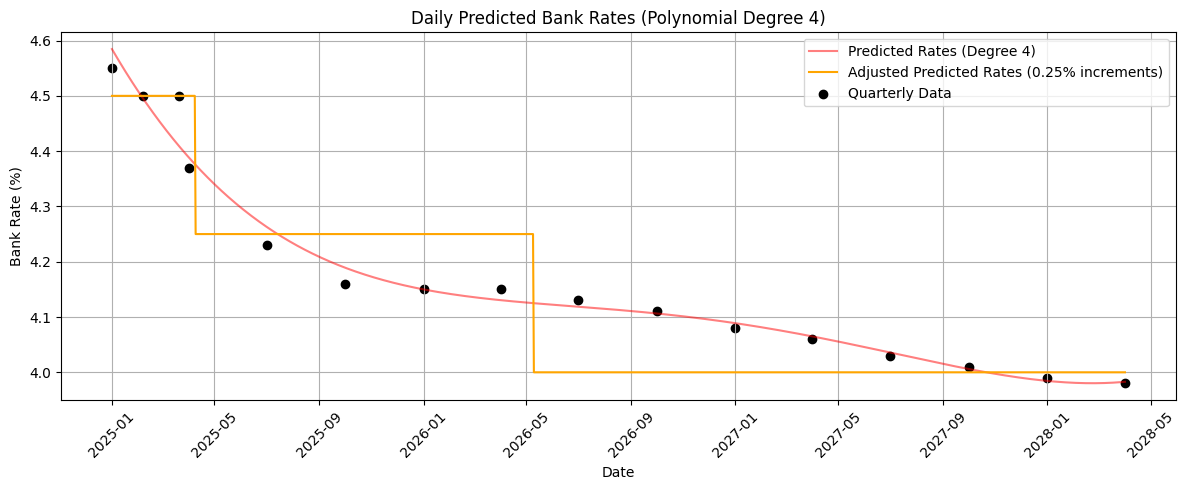

In [4]:
def generate_daily_predictions(
    start_date: pd.Timestamp, end_date: pd.Timestamp, poly: Polynomial
) -> pd.DataFrame:
    """Generate daily rate predictions using the fitted polynomial.

    Args:
        start_date: Start date for predictions.
        end_date: End date for predictions.
        poly: Fitted polynomial model.

    Returns:
        DataFrame with columns: Date, Days, Predicted_Rate, Predicted_Rate_adj.
    """
    # Create daily date index
    daily_index = pd.date_range(start=start_date, end=end_date, freq="D")
    daily_df = pd.DataFrame({"Date": daily_index})

    # Calculate days since start
    daily_df["Days"] = (
        (daily_df["Date"] - start_date).dt.total_seconds() / (24 * 3600)
    )

    # Predict rates
    daily_df["Predicted_Rate"] = poly(daily_df["Days"])

    # Round to nearest 0.25% for practical use
    daily_df["Predicted_Rate_adj"] = (
        daily_df["Predicted_Rate"] / 0.25
    ).round() * 0.25

    return daily_df

def plot_predictions(
    daily_df: pd.DataFrame, quarterly_df: pd.DataFrame, degree: int
) -> None:
    """Plot daily predictions, adjusted predictions, and quarterly data.

    Args:
        daily_df: DataFrame with daily predictions.
        quarterly_df: DataFrame with quarterly data.
        degree: Degree of the fitted polynomial.
    """
    plt.figure(figsize=(12, 5))

    # Plot continuous predictions
    plt.plot(
        daily_df["Date"],
        daily_df["Predicted_Rate"],
        label=f"Predicted Rates (Degree {degree})",
        color="red",
        alpha=0.5
    )

    # Plot adjusted predictions
    plt.plot(
        daily_df["Date"],
        daily_df["Predicted_Rate_adj"],
        label="Adjusted Predicted Rates (0.25% increments)",
        color="orange"
    )

    # Plot quarterly data points
    plt.scatter(
        quarterly_df["Date"],
        quarterly_df["Rate"],
        label="Quarterly Data",
        color="black"
    )

    plt.xlabel("Date")
    plt.ylabel("Bank Rate (%)")
    plt.title(f"Daily Predicted Bank Rates (Polynomial Degree {degree})")
    plt.legend()
    plt.grid(True)
    plt.xticks(rotation=45)
    plt.tight_layout()
    plt.show()

# Generate and plot daily predictions
daily_df = generate_daily_predictions(START_DATE, END_DATE, best_poly)
plot_predictions(daily_df, quarterly_df, best_degree)

## 4. Extract Predicted Rates on MPC Meeting Dates

This section extracts predicted rates for specific Monetary Policy Committee (MPC) meeting
dates in 2025. The results are displayed in a table, and the predicted rate for the next
meeting is highlighted.

In [5]:
def extract_mpc_predictions(
    daily_df: pd.DataFrame, target_dates: List[str]
) -> pd.DataFrame:
    """Extract predicted rates for specific MPC meeting dates.

    Args:
        daily_df: DataFrame with daily predictions.
        target_dates: List of target date strings in YYYY-MM-DD format.

    Returns:
        DataFrame with predictions for target dates.
    """
    target_dates = pd.to_datetime(target_dates)
    return daily_df.loc[
        daily_df["Date"].isin(target_dates),
        ["Date", "Predicted_Rate", "Predicted_Rate_adj"]
    ]

# MPC meeting dates
MPC_DATES: List[str] = ["2025-05-08", "2025-06-19", "2025-08-07"]

# Extract predictions
mpc_predictions = extract_mpc_predictions(daily_df, MPC_DATES)
print(mpc_predictions)

# Highlight next meeting prediction
next_meeting = "2025-05-08"
next_rate = daily_df.loc[
    daily_df["Date"] == pd.to_datetime(next_meeting), "Predicted_Rate_adj"
].values[0]
print(f"\nPredicted Bank Rate for the next MPC meeting on {next_meeting}: {next_rate}%")

          Date  Predicted_Rate  Predicted_Rate_adj
127 2025-05-08        4.330044                4.25
169 2025-06-19        4.276305                4.25
218 2025-08-07        4.228132                4.25

Predicted Bank Rate for the next MPC meeting on 2025-05-08: 4.25%
